In [3]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import requests
from PIL import Image

#Using VGG# -19 pretrained model for image classification
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

def download(url, fname):
    response = requests.get(url)
    with open(fname, "wb") as f:
        f.write(response.content)

# Downloading the image
download("https://specials-images.forbesimg.com/imageserve/5db4c7b464b49a0007e9dfac/960x0.jpg?fit=scale", "Vanilla_backprop_2.jpg")

# Opening the image
img = Image.open('Image-specific Saliency.jpg')

(-0.5, 223.5, 223.5, -0.5)

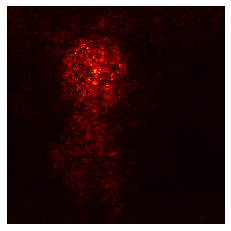

In [4]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(), dim=1)
# print(saliency.shape)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')